## Libs, Classes, Functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib as mpl
from sklearn.decomposition import PCA

In [ ]:
plt.rcParams['font.size'] = 50

In [ ]:
def generate_dataset(mu, sigma2, n, l, pi, d):
    """
    Generate a dataset with given parameters
    Args:
        mu:     mean of the positive population
        sigma2: variance of the population
        n:      number of samples
        l:      number of st. devs between the positive and minor negative Gaussians
        pi:     mixing coefficient of the negative Gaussians
    Output:
        X_pos:  dataset of the positive class
        X_neg:  dataset of the negative class
    """
    n_pos, n_maj, n_min = np.random.multinomial(n, (1 / 2, pi / 2, (1 - pi) / 2))
    X_pos = np.random.multivariate_normal(mu, sigma2, n_pos)
    X_maj = np.random.multivariate_normal(-mu, sigma2, n_maj)
    X_min = np.random.multivariate_normal(mu + l / np.sqrt(d), sigma2, n_min)
    X_neg = np.concatenate((X_maj, X_min))

    return X_pos, X_neg

In [ ]:
class Flex_GMM:

    comp_pos = 1
    comp_neg = 1
    model_pos = GaussianMixture(n_components=comp_pos)
    model_neg = GaussianMixture(n_components=comp_neg)
    p_pos = 0
    p_neg = 0

    def __init__(self, cp, cn):
        """
        cp: number of positive components
        cn: number of negative components
        """
        self.comp_pos = cp
        self.comp_neg = cn
        model_pos = GaussianMixture(n_components=self.comp_pos)
        model_neg = GaussianMixture(n_components=self.comp_neg)

    def fit(self, X_train, y):
        """
        Fits the GMM model to (X_train, y)
        """
        X_pos, X_neg = X_train[y == 1], X_train[y == 0]
        self.p_pos, self.p_neg = len(X_pos) / len(X), len(X_neg) / len(X)

        self.model_pos, self.model_neg = GaussianMixture(
            n_components=self.comp_pos
        ), GaussianMixture(n_components=self.comp_neg)
        self.model_pos.fit(X_pos)
        self.model_neg.fit(X_neg)

    def predict(self, X_test):
        """
        Predicts the output for the X_test on the existing model
        """
        score_pos = (
            np.max(self.model_pos._estimate_weighted_log_prob(X_test), axis=1)
            * self.p_pos
        )
        score_neg = (
            np.max(self.model_neg._estimate_weighted_log_prob(X_test), axis=1)
            * self.p_neg
        )
        y = np.zeros(len(X_test))
        y[score_pos > score_neg] = 1
        return y


## Decision Boudaries for the GMM classifier

In [ ]:
# defining properties for the training set
d = 2                               # dimensionality of the data
mu = np.array(d * [2/np.sqrt(d)])   # mean of positive population
l = 2 * mu * np.sqrt(d)             # number of std. devs between positive and minor negative populations
pi = 0.9                            # weight of major negative population
sigma = np.eye(d) / d               # variance
n = 300                             # number of val samples

In [ ]:
X_pos, X_neg = generate_dataset(mu, sigma, n, l, pi, d)
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((np.ones(X_pos.shape[0]), np.zeros(X_neg.shape[0])))

In [ ]:
f_gmm0 = Flex_GMM(3, 71)
f_gmm0.fit(X, y)

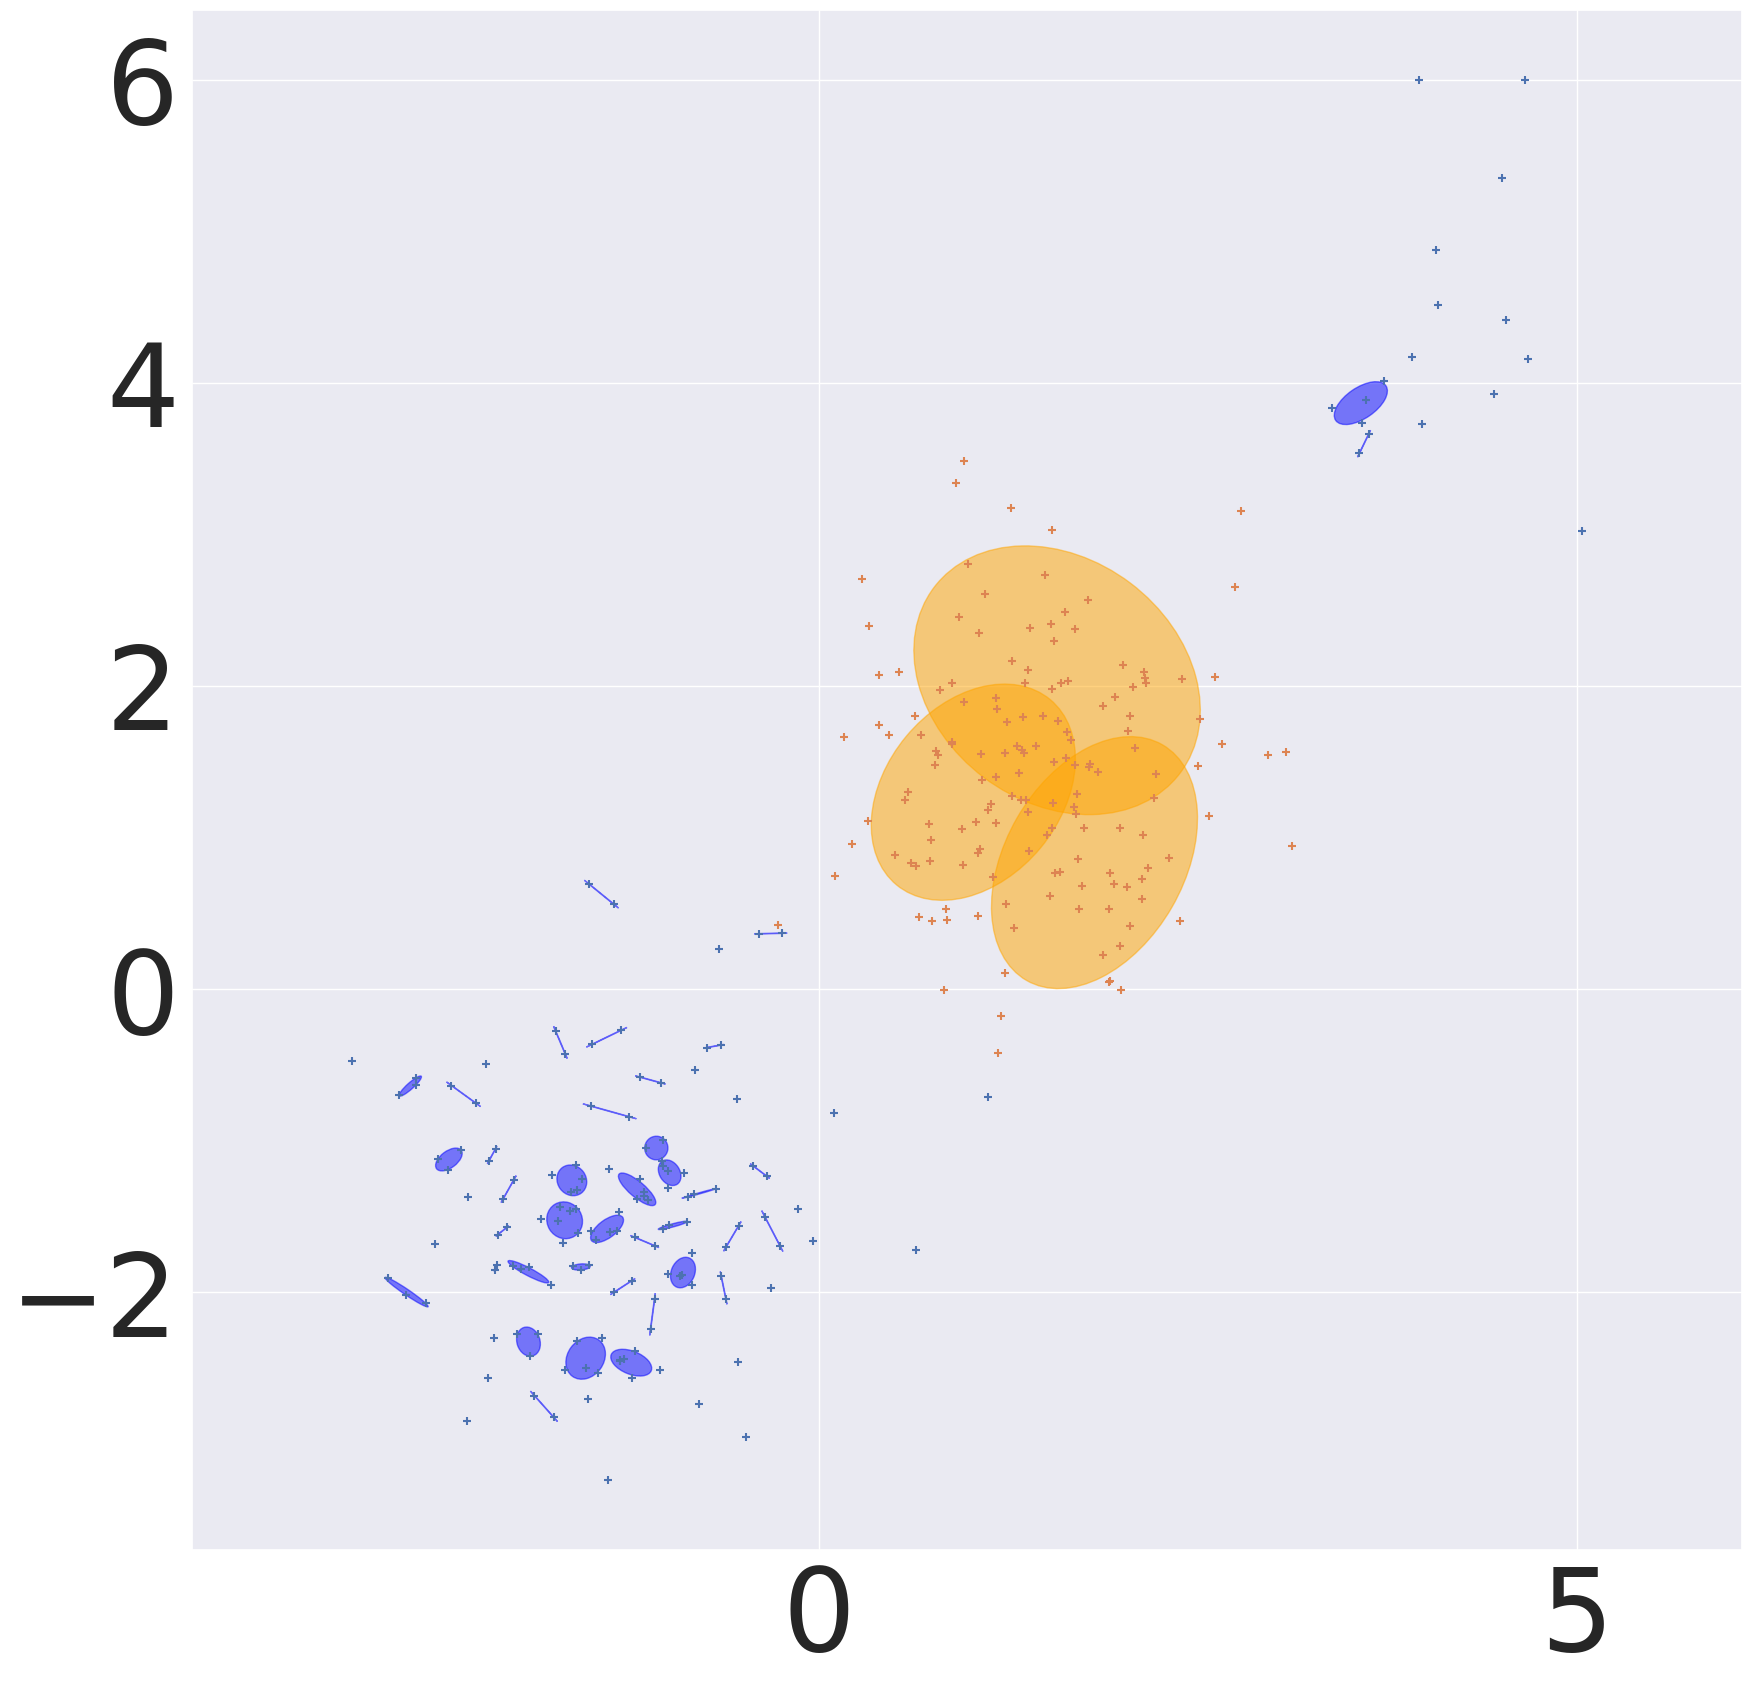

In [ ]:
plt.figure(figsize=(20, 20))
ax = plt.subplot()

gmp = f_gmm0.model_neg
for i in range(gmp.n_components):
    covariances = gmp.covariances_[i]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(
        gmp.means_[i, :2], v[0], v[1], angle=180 + angle, color="blue"
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect("equal", "datalim")

gmp = f_gmm0.model_pos
for i in range(gmp.n_components):
    covariances = gmp.covariances_[i]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(
        gmp.means_[i, :2], v[0], v[1], angle=180 + angle, color="orange"
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect("equal", "datalim")

plt.scatter(X_neg[:, 0], X_neg[:, 1], alpha=1, label="negative", marker="+")
plt.scatter(X_pos[:, 0], X_pos[:, 1], alpha=1, label="positive", marker="+")

plt.show()

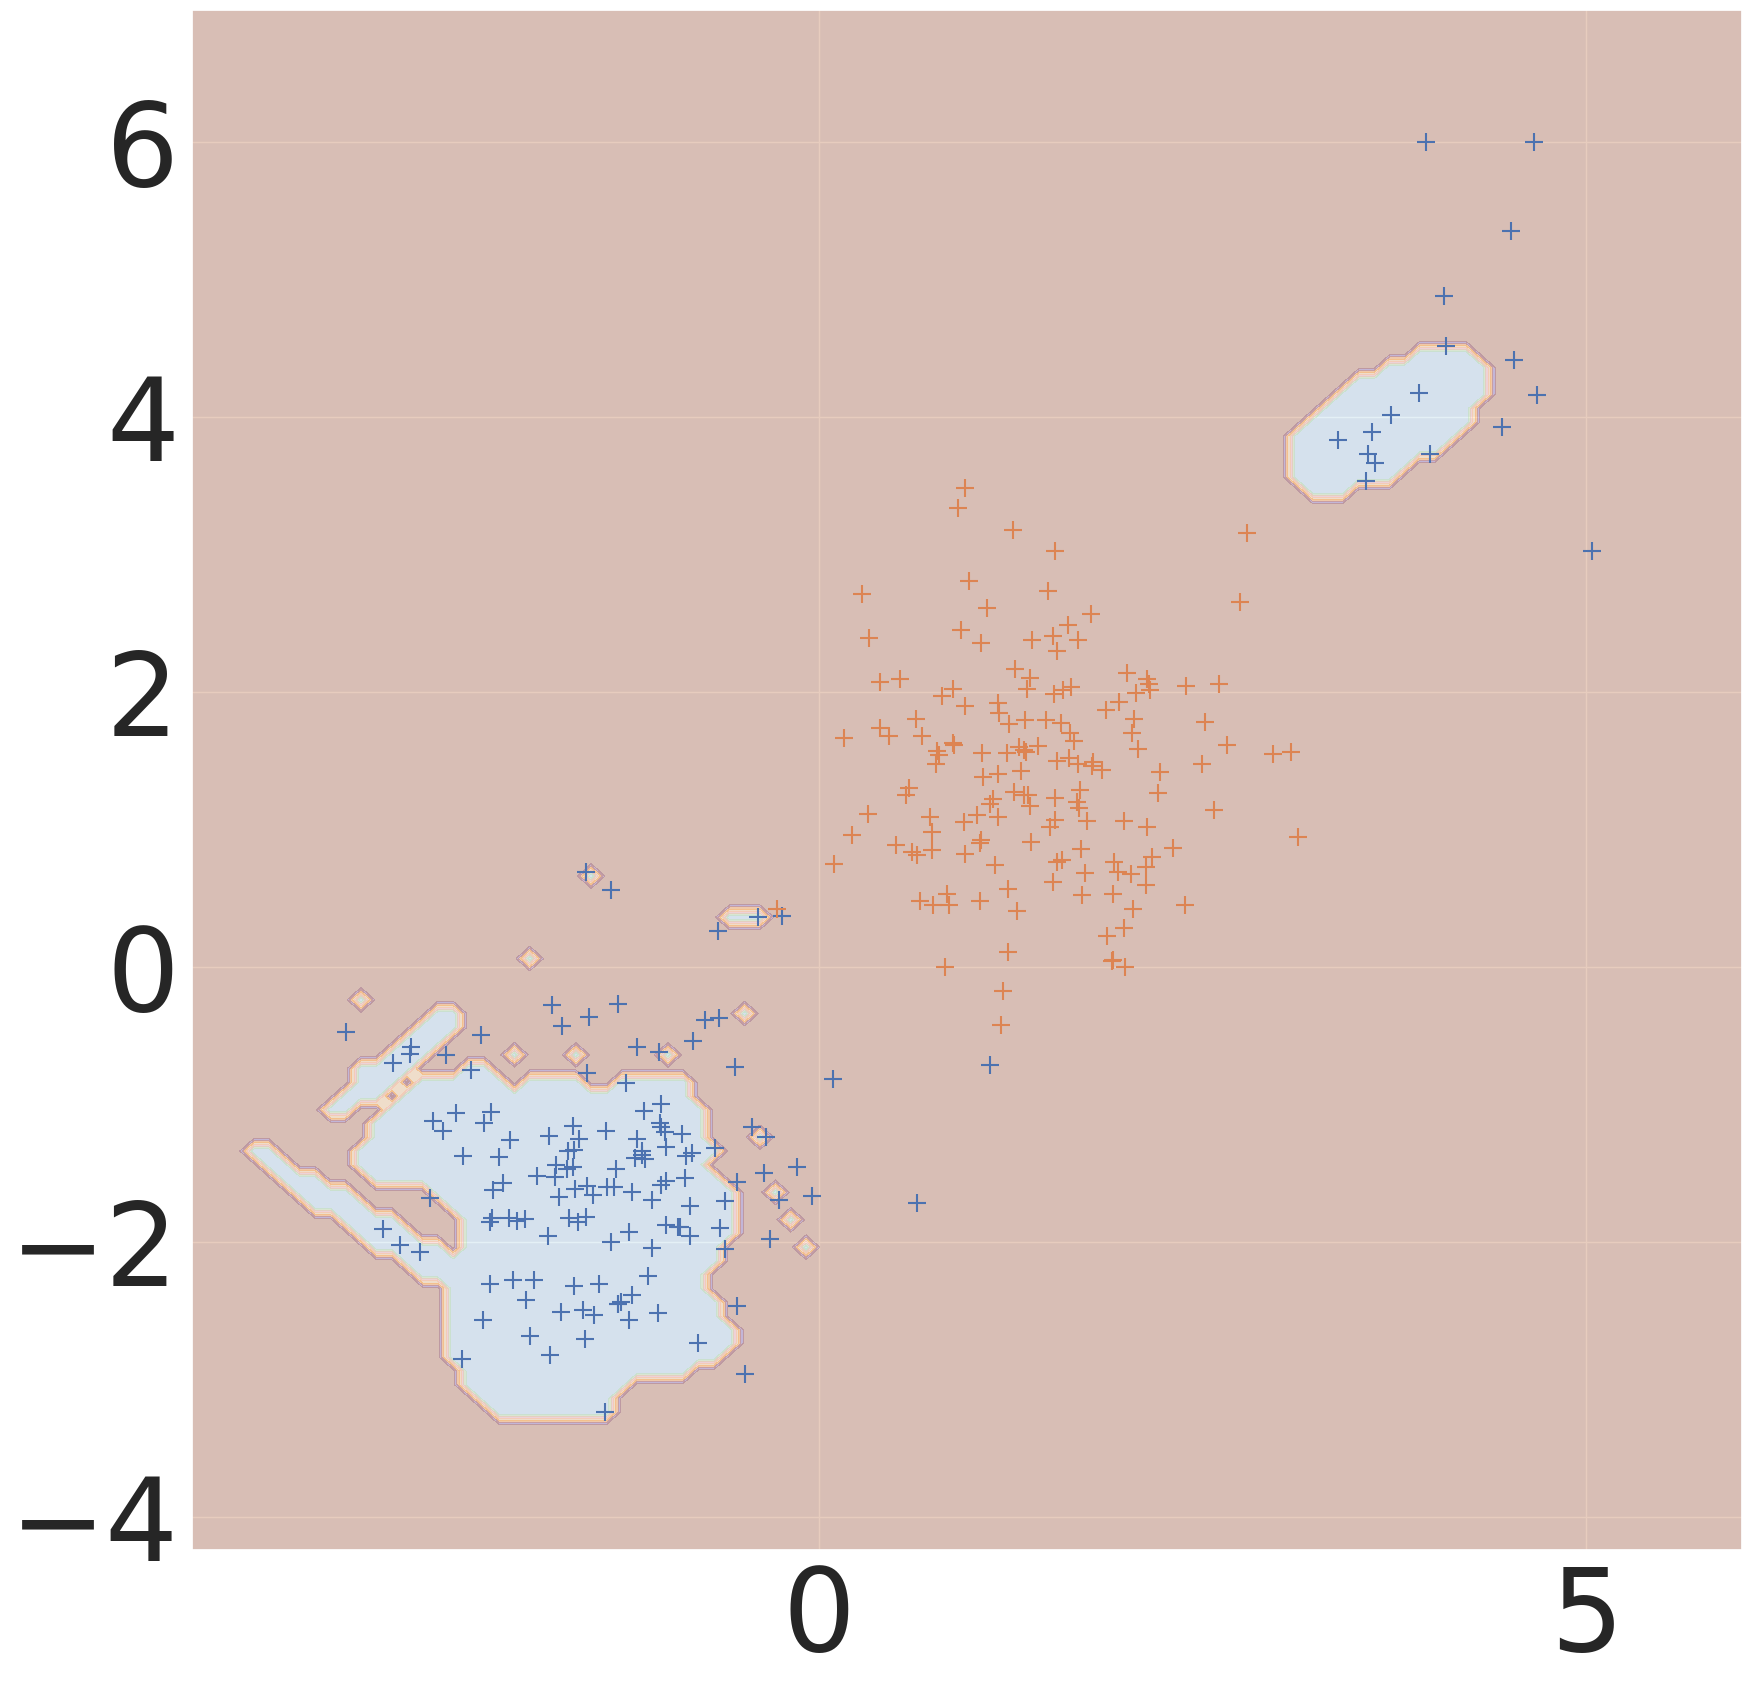

In [ ]:
plt.figure(figsize = (20, 20))

min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
y_hat = f_gmm0.predict(grid)
zz = y_hat.reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap='Paired', alpha = 0.3)


plt.scatter(X_neg[:, 0], X_neg[:, 1], alpha=1, label='negative', marker = '+', s = 150)
plt.scatter(X_pos[:, 0], X_pos[:, 1], alpha=1, label='positive', marker = '+', s = 150)

plt.show()

In [ ]:
n_test = 1000

X_pos_test, X_neg_test = generate_dataset(mu, sigma, n_test, l, pi, d)
X_test = np.concatenate((X_pos_test, X_neg_test))
y_test = np.concatenate((np.ones(X_pos_test.shape[0]), np.zeros(X_neg_test.shape[0])))

In [ ]:
y_hat = f_gmm0.predict(X_test)
acc = accuracy_score(y_hat, y_test)

In [ ]:
acc

0.807

## Accuracy vs number of positive and negative components

In [ ]:
d = 50
mu = np.array(d * [2/np.sqrt(d)])
l = 2 * mu * np.sqrt(d)
pi = 0.
sigma = np.eye(d)
m = 10
n_train = 200
n_test = 1000

cp_range = range(1, 72, 10) # set of values for number of positive components
cn_range = range(1, 72, 10) # set of values for number of negative components

In [ ]:
# creating the test set
X_pos_test, X_neg_test = generate_dataset(mu, sigma, n_test, l, pi, d)
X_test = np.concatenate((X_pos_test, X_neg_test))
y_test = np.concatenate((np.ones(X_pos_test.shape[0]), np.zeros(X_neg_test.shape[0])))

Xs = []
ys = []

# generating m training sets
for _ in range(m):
  X_pos_train, X_neg_train = generate_dataset(mu, sigma, n_train, l, pi, d)
  X_train = np.concatenate((X_pos_train, X_neg_train))
  y_train = np.concatenate((np.ones(X_pos_train.shape[0]), np.zeros(X_neg_train.shape[0])))
  Xs.append(X_train)
  ys.append(y_train)

M = np.zeros((len(cp_range), len(cn_range)))
N = np.zeros((len(cp_range), len(cn_range)))

FM = np.zeros((len(cp_range), len(cn_range), m))
FN = np.zeros((len(cp_range), len(cn_range), m))

In [ ]:
# calcualting the average error over 10 models for each pair of (k+, k-)

for i in range(len(cp_range)):
  for j in range(len(cn_range)):
    acc_test = 0
    acc_train = 0
    for X, y, k in zip(Xs, ys, range(m)):
      f_gmm = Flex_GMM(cp_range[i], cn_range[j])
      f_gmm.fit(X, y)

      y_hat = f_gmm.predict(X)
      acc_train += accuracy_score(y_hat, y)
      FN[i, j, k] = accuracy_score(y_hat, y)

      y_hat = f_gmm.predict(X_test)
      acc_test += accuracy_score(y_hat, y_test)
      FM[i, j, k] = accuracy_score(y_hat, y_test)

    acc_test /= m
    acc_train /= m
    M[i, j] = 1 - acc_test
    N[i, j] = 1 - acc_train

In [ ]:
M_flipped = np.flip(M, axis = 0)
N_flipped = np.flip(N, axis = 0)

cp_range = np.flip(np.array(cp_range))

In [ ]:
sns.set(font_scale = 7.5)

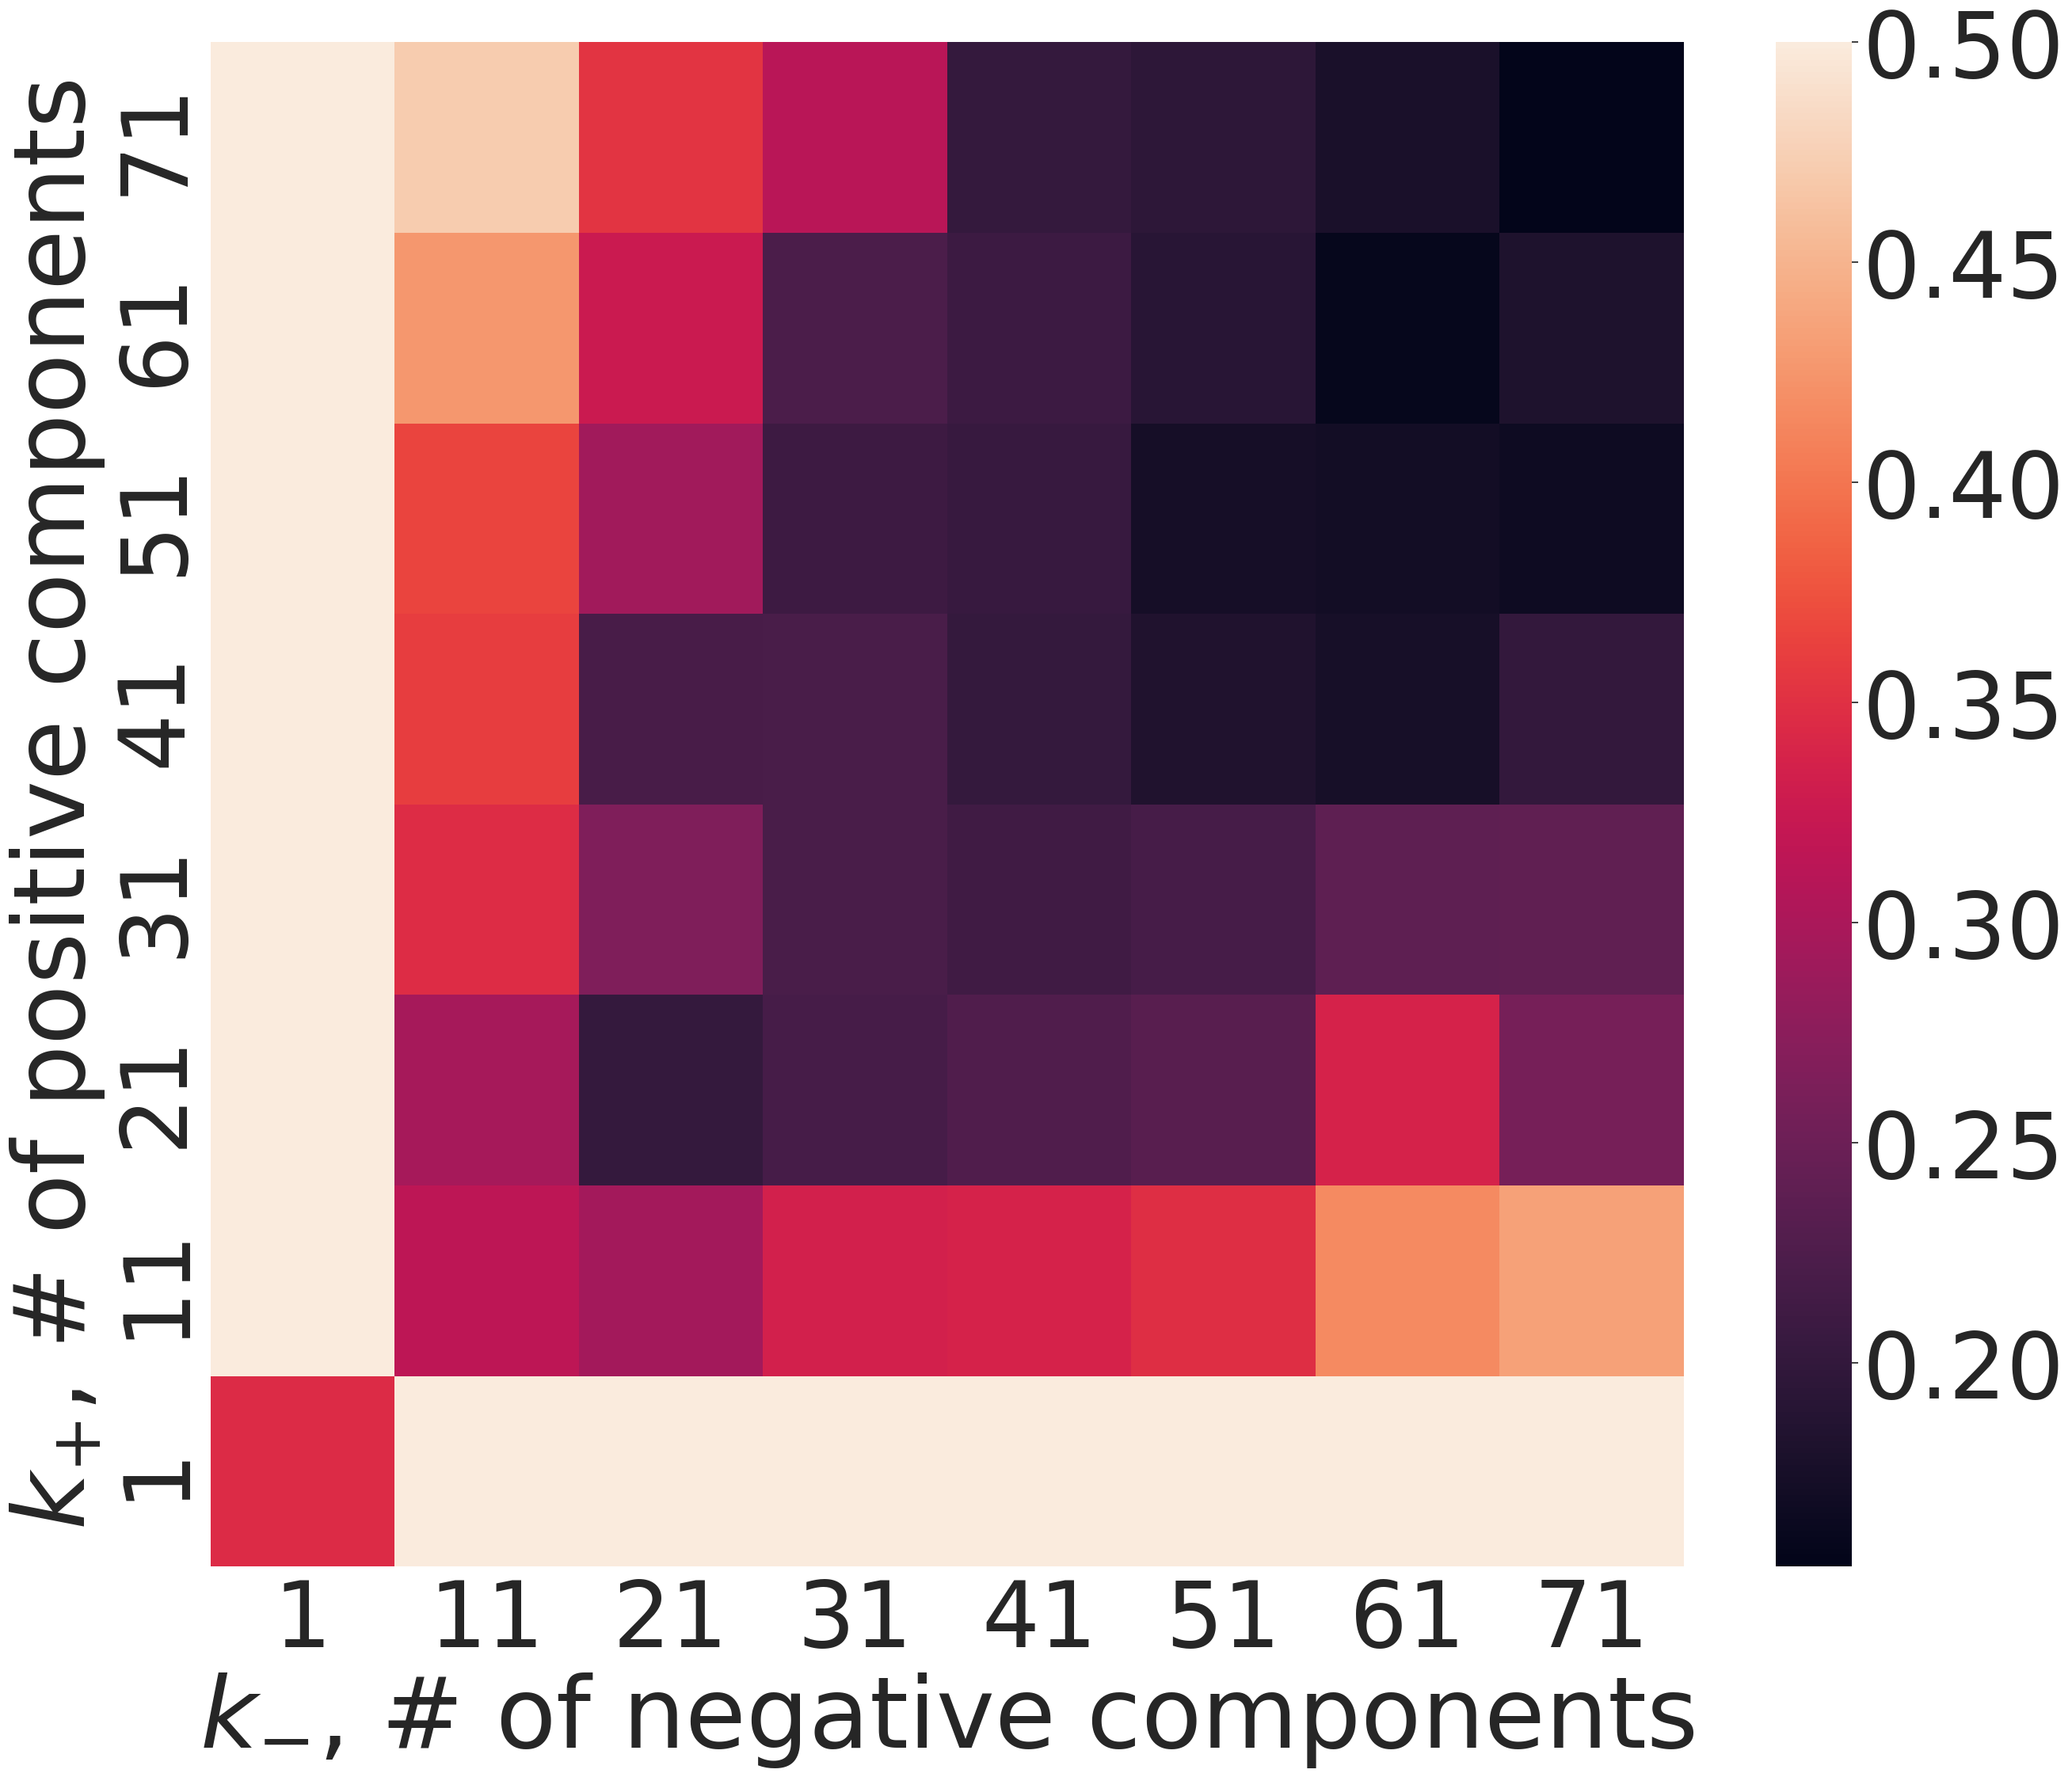

In [ ]:
# heatmap of the test error

plt.figure(figsize = (30, 25))
sns.heatmap(M_flipped, xticklabels = cn_range, yticklabels = cp_range)
plt.xlabel('$k_{-}$, # of negative components')
plt.ylabel('$k_{+}$, # of positive components')

plt.show()

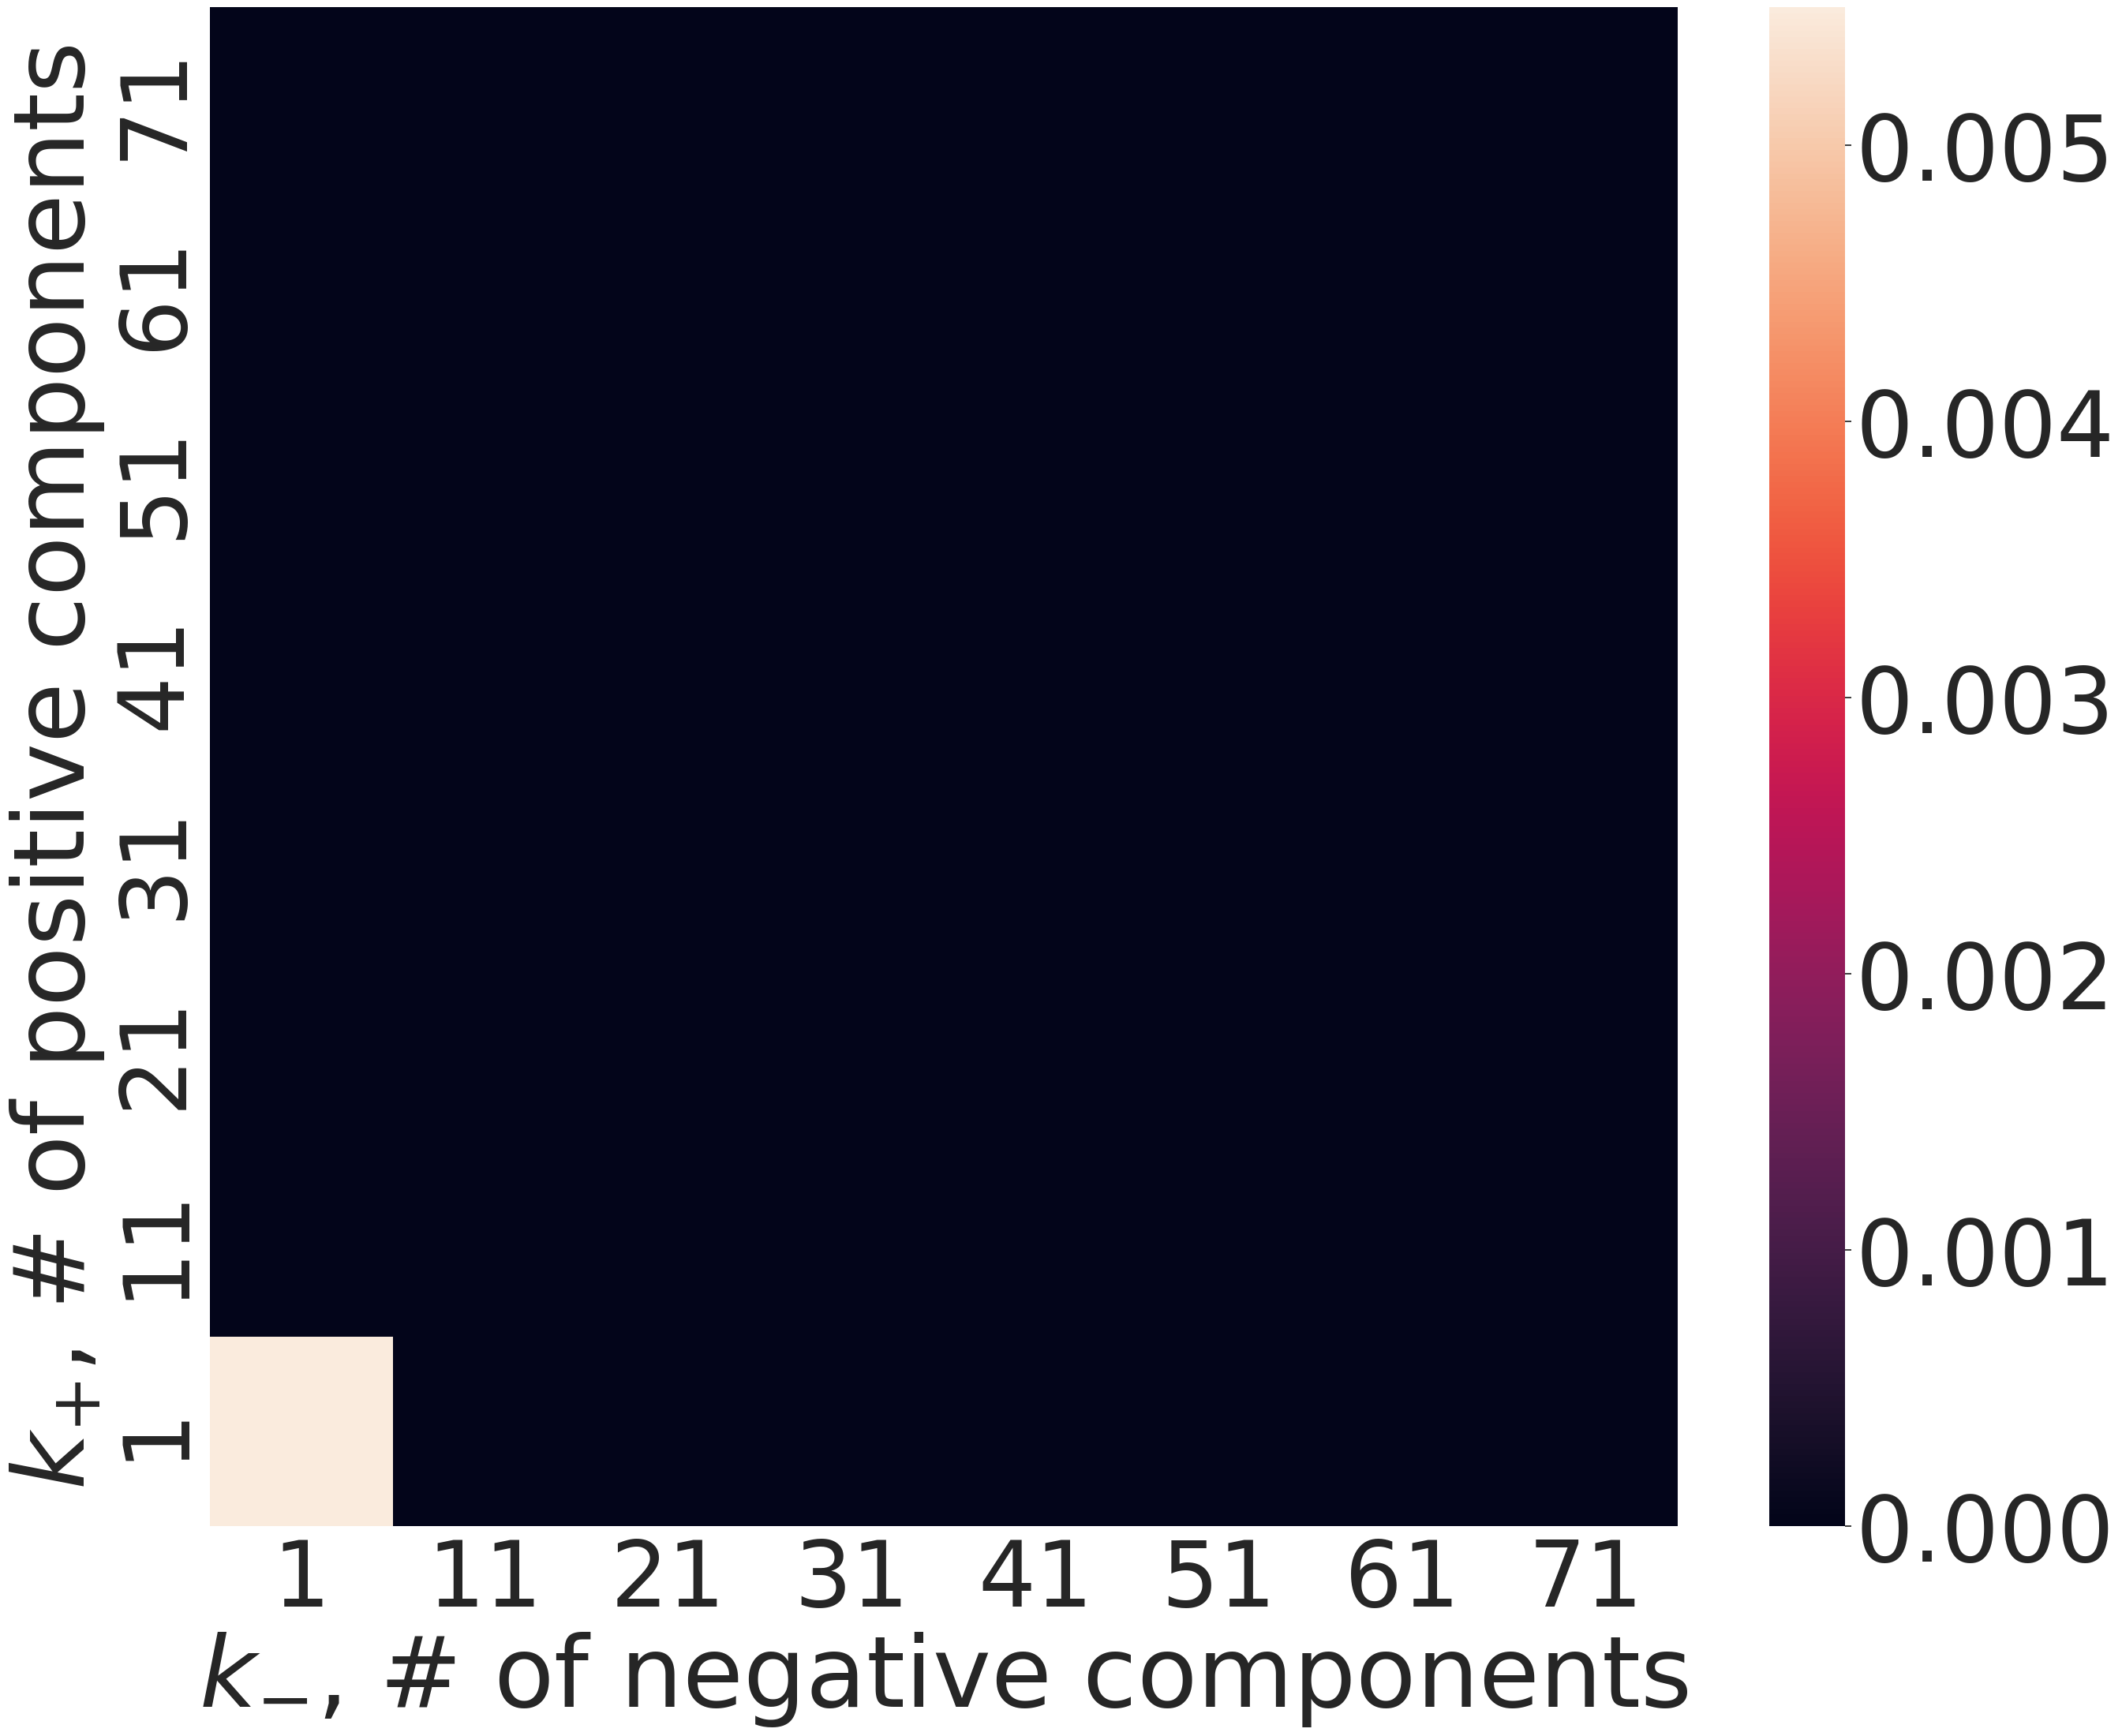

In [ ]:
# heatmap for the train error

plt.figure(figsize = (30, 25))
sns.heatmap(N_flipped, xticklabels = cn_range, yticklabels = cp_range)
plt.xlabel('$k_{-}$, # of negative components')
plt.ylabel('$k_{+}$, # of positive components')
plt.show()